# 1. Data Loading

Let's look at the data and the possible imbalance

Importing the required libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

let's designate the path as a variable so as not to write a long path

In [ ]:
path = '../data'

Let's look at the data distribution. As we can see, there is a strong imbalance in the data (there are many times more X-rays with pneumonia than normal ones), there are many solutions to the imbalance problem. I offer my solution below.

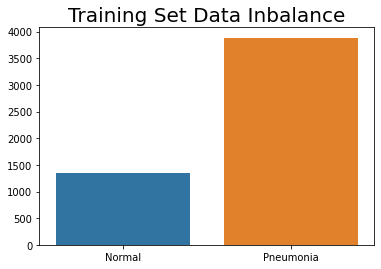

In [ ]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

I suggest increasing the dataset with normal x-rays. The difference between the pneumonia renegens and the normal ones is 2534, that is, in order to level, we need to add 2534 normal X-rays. Since there are only 1341 normal images in the 'train' folder, we will take the missing 1193 images from the third dataset. To prevent duplicate objects in the final dataset, I applied unique augmentation for each dataset.

Here are the augmentations for datasets

In [ ]:
transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

Let's create datasets and concatenate them

In [ ]:
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])

len(dataset)

7779

We know in advance what classes there are, but sometimes it is useful to be able to view classes from the dataset

In [ ]:
print(dataset1.classes)

['NORMAL', 'PNEUMONIA']


Let's display X-rays with diagnoses. To be honest, I don't see any difference between a pneumonia X-ray and a normal X-ray)

In [ ]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

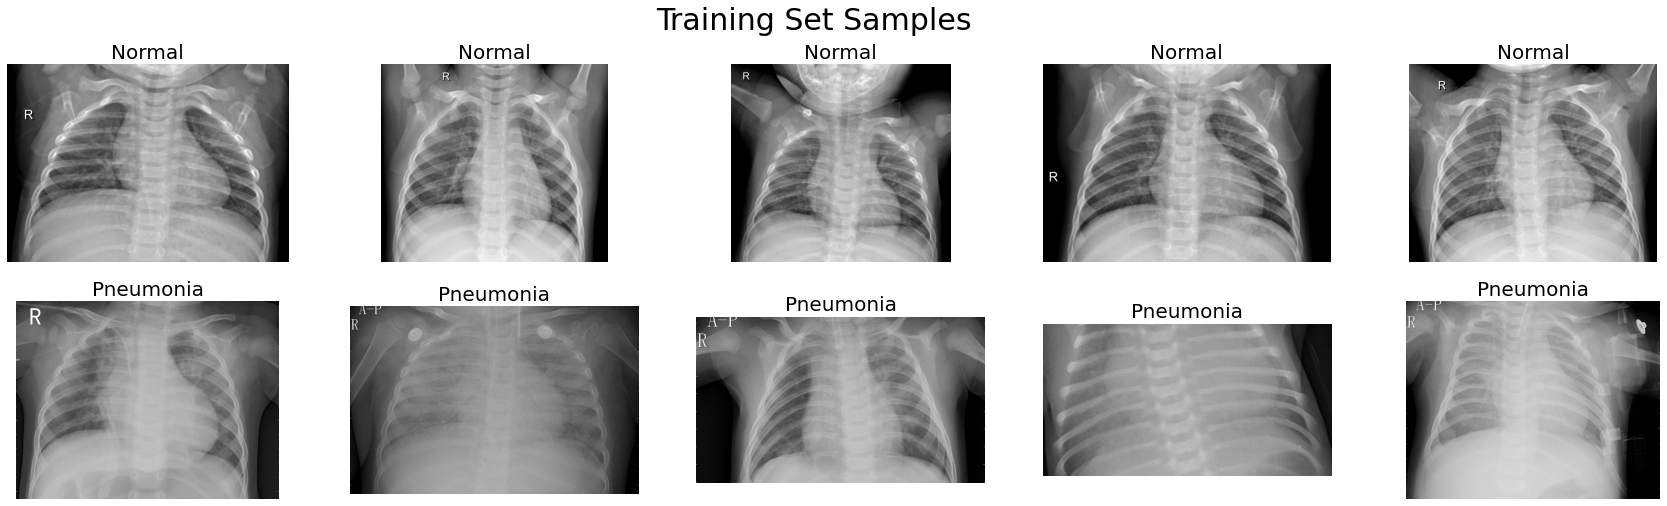

In [ ]:
rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename) 
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

# 2. Preparing Train, Validation

In this part, we will split the 'train' folder into validation and training parts. It seems strange, because there is a separate folder with validation, but the fact is that there are only 16 images and this is clearly not enough to adequately evaluate the model, so you have to sacrifice part of the data for validation. We will split the data in a ratio of 3/10, of course, in favor of the training data.

In [ ]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed);

In [ ]:
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5445, 2334)

Let's wrap the data into dataloaders. We will also create a dictionary with dataloggers in order to have quick access to them and a dictionary with their sizes, this will be useful to us for evaluating the model

In [ ]:
batch_size=50

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's see what the data with augmentation looks like.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


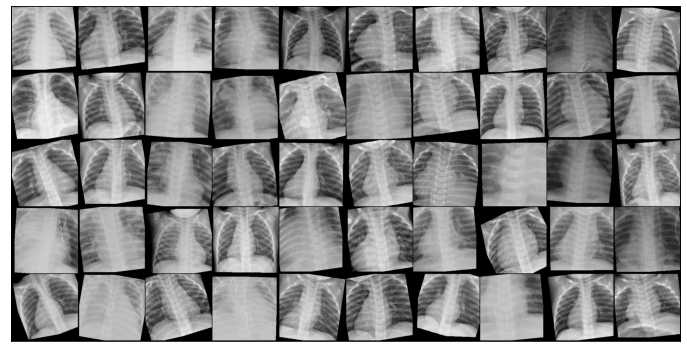

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# 3. Creating Model

In the third part, we will create the model. We will take a ready-made densenet network and work with it

Since we will have to calculate the accuracy several times, we will write in advance the function for calculating the accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

Here I would like to stop and explain the idea in more detail.
Often, a dataset for a task for training a network contains few objects. And if you train the network on this dataset from scratch, the network will be retrained.
Idea: to use the knowledge gained by other networks on similar tasks.
I will be using DenseNet. DenseNet has many advantages: strong gradient flow, the number of layers and parameters is not very large, conv layers highlight more diverse features, the lower conv layers take into account the low, complex patterns from the upper layers, which can be useful for detecting some low-level patterns. It also helps DenseNet learn better on small datasets.


DenseNet is good for dealing with vanishing gradients. If you do not know what it is, I will add a rather short but complete description at the bottom. DenseNet is good for dealing with vanishing gradients. If you do not know what it is, I will add a fairly short but complete description at the bottom. In short, the longer the network, the smaller the change in weight to reaches the first layers, because the number of multipliers less than 1 increases.

Let's create a pre-trained network

In [ ]:
model = torchvision.models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

The upper (first) layers of the network are frozen, the lower ones are retrained. The upper layers highlight low-level information, and they've learned to do this well in pre-training. The lower layers are separated from the information obtained from the upper layers, information specific to the task, so they need to be retrained.

How many layers to freeze depends on the difference between the datasets, the complexity of the task and the size of the dataset for additional training. DenseNet has only one fully connected layer, so we'll only train it, and freeze the rest of the network. We will also change the last layer, since it was originally trained in 1000 classes, and we have only 2

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 3)

NameError: ignored

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Training function

In [ ]:
def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

I would like to draw your attention to the fact that in the optimizer we specify only the classifier

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [ ]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/10
train - loss:0.2940011241082427, accuracy0.9010101010101009
val - loss:0.17621553677111074, accuracy0.9541559554413025
Time: 0.0m 54.182591676712036s
Epoch: 2/10
train - loss:0.15784853015392608, accuracy0.9533516988062443
val - loss:0.14297910070409098, accuracy0.9528706083976007
Time: 1.0m 49.47631764411926s
Epoch: 3/10
train - loss:0.14702499020909693, accuracy0.9504132231404958
val - loss:0.15790571748648533, accuracy0.9417309340188518
Time: 2.0m 45.75517821311951s
Epoch: 4/10
train - loss:0.12324182448363064, accuracy0.9561065197428833
val - loss:0.11179440561123352, accuracy0.9635818337617824
Time: 3.0m 42.35771298408508s
Epoch: 5/10
train - loss:0.10275982453379202, accuracy0.965289256198347
val - loss:0.11407641969436035, accuracy0.9627249357326478
Time: 4.0m 38.646069049835205s
Epoch: 6/10
train - loss:0.10795602711093766, accuracy0.9623507805325987
val - loss:0.11295250184585012, accuracy0.9618680377035134
Time: 5.0m 34.685137033462524s
Epoch: 7/10
train - loss:0.

It is good practice to retrain the rest of the network after we have trained the last layer. In most cases, this leads to an increase in performance, but in my practice there have been cases when, due to a small dataset, this led to a performance degradation, so my advice is to check two options. Learning rate can be reduced by 10 times

In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.to(device)
grad_clip = None
weight_decay = 1e-4
# weighted loss for data class imbalance
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/10
train - loss:0.08798148180807097, accuracy0.9691460055096418
val - loss:0.05238663942426213, accuracy0.9820051413881749
Time: 2.0m 39.38360571861267s
Epoch: 2/10
train - loss:0.021778715017289726, accuracy0.9917355371900826
val - loss:0.04752438067320507, accuracy0.9820051413881749
Time: 5.0m 18.591246843338013s
Epoch: 3/10
train - loss:0.009247926707851408, accuracy0.9977961432506887
val - loss:0.06408337699792059, accuracy0.9798628963153385
Time: 7.0m 57.70641231536865s
Epoch: 4/10
train - loss:0.013815280763844808, accuracy0.9950413223140495
val - loss:0.06673280093675255, accuracy0.9832904884318766
Time: 10.0m 36.9653103351593s
Epoch: 5/10
train - loss:0.004589412905533534, accuracy0.9985307621671258
val - loss:0.06217479442175232, accuracy0.9832904884318766
Time: 13.0m 16.164642572402954s
Epoch: 6/10
train - loss:0.013860213407043718, accuracy0.9955922865013773
val - loss:0.0698715164433868, accuracy0.9760068551842331
Time: 15.0m 55.49072217941284s
Epoch: 7/10
train - 

In [ ]:
# Save Model
bestmodel = {
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict()
}
now = datetime.now()
date_in_string = now.strftime('%d%m%Y%H%M%S')
torch.save(bestmodel, f'./pneumonia-{date_in_string}.pth')
torch.save(bestmodel, './pneumonia-last.pth')

In [ ]:
# this is for loading the model from a previously saved one

# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = torchvision.models.densenet161(pretrained=True)
#     model.load_state_dict(checkpoint['state_dict'])
#     for parameter in model.parameters():
#         parameter.requires_grad = False
#
#     model.eval()
#     return model
#
# model = load_checkpoint('./PneumoniaResnet.pth')

# 4. Plots Accuracy and Loss

Let's display our results to see how the idea worked with additional training of the entire network, whether we selected the learning rate correctly and whether the network is being retrained. As you can see from the graph, the idea worked and we really increased productivity. (attention to the network after the 10th epoch)

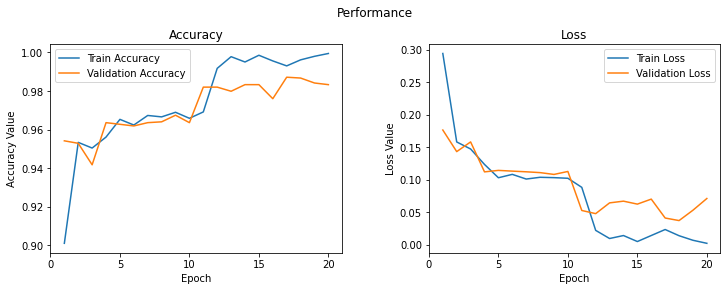

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs*2+1))
ax1.plot(epoch_list, list(map(lambda x: x.cpu(), accuracies['train'])), label='Train Accuracy')
ax1.plot(epoch_list, list(map(lambda x: x.cpu(), accuracies['val'])), label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs*2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs*2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# 5. Test

Now look at the X-ray-trained network on data it has never seen.

The test data also shows an imbalance

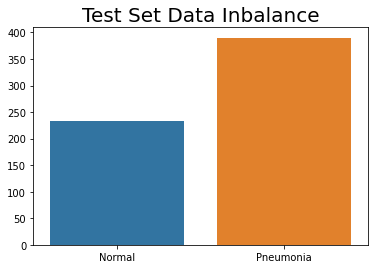

In [ ]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/test/NORMAL', filename) 
                     for filename in os.listdir(path+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

The following three functions are needed to calculate metrics

In [ ]:
def validation_step(batch):
        images, labels = batch
        images, labels = images.to(device),labels.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)

        return {
            'val_loss': loss.detach(),
            'val_acc': acc.detach(),
            'preds': preds.detach(),
            'labels': labels.detach()
        }

In [ ]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {
            'test_loss': epoch_loss.item(),
            'test_acc': epoch_acc.item(),
            'test_preds': batch_preds,
            'test_labels': batch_labels
        }

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

Let's create a dataset with training x-rays

In [ ]:
testset = ImageFolder(path+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),
                                                 transform.ToTensor(),
                                                ]))

Evaluate test set

In [ ]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.3896, test_acc: 0.9191


# 6. Calculation of some more metrics and visualization of predictions

<Figure size 432x288 with 0 Axes>

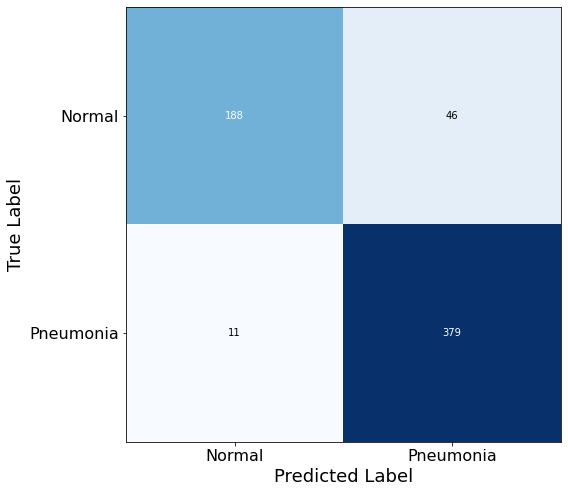

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

Next, let's calculate recall, precision and f1 score. This is one of the most key metrics for classification problems.

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.91
Recall of the model is 0.97
Precision of the model is 0.89
F1 Score of the model is 0.93


Look at X-rays and predictions

In [ ]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = testset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(testset.classes[label], 
                                    testset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

We can also see how strongly the neural network is confident in certain decisions.

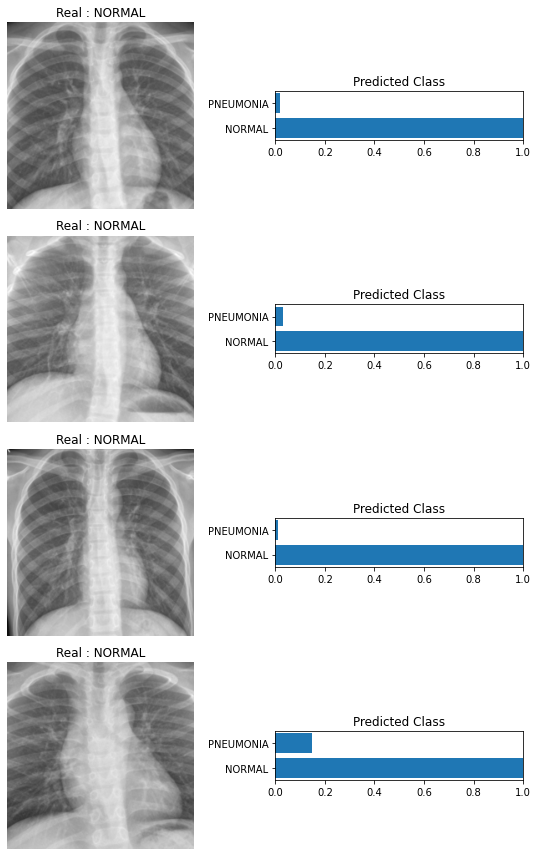

In [ ]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    img,label = testset[row]
    pred = torch.exp(model(img.to(device).unsqueeze(0)))
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)
    pred = pred.cpu().data.numpy().squeeze()
    ax[row][0].imshow(img.permute(1, 2, 0))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, pred)
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_yticklabels(classes)
    ax[row][1].set_title('Predicted Class')
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()